# Training a CNN with Text Supervision

In [1]:
import torch
from torchvision import models
from torch.utils.data import DataLoader
import torch.nn as nn
from instadata import InstaData
from pathlib import Path

torch.cuda.is_available()

True

## Load datasets

In [15]:
dataloaders = dict()
for mode in "train", "validate", "test":
    dataloaders[mode] = torch.utils.data.DataLoader(InstaData(mode), batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

In [19]:
for k in dataloaders:
    print(f"{k}: {len(dataloaders[k])} batchs")

train: 12501 batchs
validate: 782 batchs
test: 1977 batchs


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


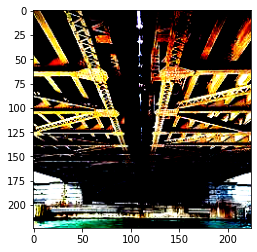

In [4]:
import matplotlib.pyplot as plt
_, img, caption = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))

In [5]:
print(f"Size of an image: {img.shape}")
torch.unsqueeze(img, 0).shape

Size of an image: torch.Size([3, 224, 224])


torch.Size([1, 3, 224, 224])

In [6]:
model = models.resnet50(pretrained=True)
v = next(iter(val_loader))

In [7]:
v[2].shape

torch.Size([64, 20])

## Train model

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
model.fc = nn.Linear(model.fc.in_features, 20)
model = model.to(device)

In [24]:
import copyimport time

def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validate']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders)

NameError: name 'copy' is not defined